In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata

In [2]:
ls

aclim_era5_sfc_1981_2010.ctl
aclim_era5_sfc_1981_2010_flament-et-al-2013_1d.nc
aclim_era5_sfc_1981_2010.grd
aclim_era5_sfc_1981_2010_kaban-et-al-2003.nc
aclim_era5_sfc_1981_2010_modified.ctl
aclim_era5_sfc_1981_2010_modified.ctl~
aclim_era5_sfc_1981_2010_modified_orography.nc
aclim_era5_sfc_1981_2010.nc
aclim_era5_sfc_1981_2010_panasyuk-hager-2000.nc
aclim_era5_sfc_1981_2010_steinberger-2007.nc
annual_precip_anomaly_FLA.png
annual_precip_anomaly_KAB.png
annual_precip_anomaly_RHO.png
annual_precip_anomaly_STE.png
annual_precip_CTL.png
annual_precip_FLA.png
annual_precip_KAB.png
annual_precip_RHO.png
annual_precip_STE.png
dynamic_topography_forcing.ipynb
dynamic_with_shallow_structure_spot.dat
dynamic_with_shallow_structure_spot_shiptrack.dat
dyn_top_map_flament-et-al-2013_1d.png
dyn_top_mapflament-et-al-2013_1d.png
dyn_top_map_kaban-et-al-2003.png
dyn_top_mapkaban-et-al-2003.png
dyn_top_map_panasyuk-hager-2000.png
dyn_top_mappanasyuk-hager-2000.png
dyn_top_map_steinberger-2007.png
dyn_t

In [ ]:
df = pd.read_csv('with_shallow_structure_full.dat', sep='\s+')
df

In [ ]:
fig = plt.figure(figsize=(16,8))
sc = plt.scatter(df.lon,df.lat,c=df.value_km,cmap='seismic',vmin=-5,vmax=5)
plt.colorbar(sc)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.xlabel('Longitude [°E]',fontsize=14)
plt.tick_params(axis='both',labelsize=14)

plt.savefig('dyn_with_shallow_structure_full_scatter_data.png')

In [ ]:
# Try to interpolate the data on a regular grid of 0.25°

grid_x, grid_y = np.mgrid[-180:180:0.25, -90:90:0.25]
grid_x

In [ ]:
interp_dyn_top = griddata((df.lon,df.lat),df.value_km,(grid_x, grid_y), method='linear')

In [ ]:
fig = plt.figure(figsize=(16,8))
sc = plt.pcolormesh(grid_x,grid_y,interp_dyn_top,cmap='seismic',vmin=-5,vmax=5,shading='nearest')
plt.colorbar(sc)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.xlabel('Longitude [°E]',fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.title('Dynamic topography [km]',fontsize=16)

plt.savefig('dyn_with_shallow_structure_full.png')

In [ ]:
def nan_gaussian_filter(field,sigma):
    """
    Function to smooth the field ignoring the NaNs.
    I follow the first answer here 
    https://stackoverflow.com/questions/18697532/gaussian-filtering-a-image-with-nan-in-python
    By default, the filter is truncated at 4 sigmas.
    """
    from scipy.ndimage import gaussian_filter
    
    field = np.double(field)
    
    # Take the original field and replace the NaNs with zeros.
    field0 = field.copy()
    field0[np.isnan(field)] = 0
    ff = gaussian_filter(field0, sigma=sigma)
    
    # Create the smoothed weight field.
    weight = 0*field.copy()+1
    weight[np.isnan(field)] = 0
    ww = gaussian_filter(weight, sigma=sigma)
    
    zz = ff/(ww*weight) # This rescale for the actual weights used in the filter and set to NaN where the field
                        # was originally NaN.
    return zz


In [ ]:
# Let's try to filter this figure with a low-pass filter.

lp_interp_dyn_top = nan_gaussian_filter(interp_dyn_top,40) # we filter with a sigma of 10 degrees

fig = plt.figure(figsize=(16,8))
sc = plt.pcolormesh(grid_x,grid_y,lp_interp_dyn_top,cmap='seismic',vmin=-2,vmax=2,shading='nearest')
plt.colorbar(sc)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.xlabel('Longitude [°E]',fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.title('Dynamic topography [km]',fontsize=16)

plt.savefig('dyn_with_shallow_structure_full_filtered.png')

In [ ]:
# Now read the file that Pietro modified (20241017) - the file is the same as before...
df = pd.read_csv('with_shallow_structure_full_PSsmoothing.dat', sep='\s+')
df

In [ ]:
# Interpolate and plot
grid_x, grid_y = np.mgrid[-180:180:0.25, -90:90:0.25]
grid_x

interp_dyn_top = griddata((df.lon,df.lat),df.value_km,(grid_x, grid_y), method='linear')

fig = plt.figure(figsize=(16,8))
sc = plt.pcolormesh(grid_x,grid_y,interp_dyn_top,cmap='seismic',vmin=-2,vmax=2,shading='nearest')
plt.colorbar(sc)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.xlabel('Longitude [°E]',fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.title('Dynamic topography [km]',fontsize=16)

#plt.savefig('dyn_with_shallow_structure_full.png')

In [ ]:
# Read the SPEEDY orography file.
# It is the aclim_era5_sfc_1981_2010.grd file. I edit its ctl file to remove the line 
# EDEF       1  NAMES  1,
# because it is not recognized by cdo. Then, as it seems that the data are in the first time stamp only, 
# even though the file has 12 time steps I modify the 
# TDEF      12  LINEAR    jan1981     1mo
# line replacing the 12 with 1.
# I also remove the YREV keyword.

# I convert the file with 
# cdo -v -f nc import_binary aclim_era5_sfc_1981_2010_modified.ctl aclim_era5_sfc_1981_2010.nc

orogr_filename = 'aclim_era5_sfc_1981_2010.nc'
ds_or = xr.open_dataset(orogr_filename)
ds_or

In [ ]:
ds_or.orog.plot()

In [ ]:
# Interpolate the dynamical topography on the SPEEDY grid.
slon = ds_or.lon.values
slat = ds_or.lat.values
grid_x, grid_y = np.meshgrid(slon,slat)

# Change negative df.lon with df.lon+360
lon360 = df.lon
lon360[df.lon<0] = df.lon+360

a_interp_dyn_top = griddata((lon360,df.lat),df.value_km,(grid_x, grid_y), method='linear')
interp_dyn_top = np.flipud(a_interp_dyn_top) # This is to flip upside down the 

In [ ]:
fig = plt.figure(figsize=(16,8))
sc = plt.pcolormesh(grid_x,grid_y,interp_dyn_top,cmap='seismic',vmin=-2,vmax=2,shading='nearest')
plt.colorbar(sc)
plt.ylabel('Latitude [°N]',fontsize=14)
plt.xlabel('Longitude [°E]',fontsize=14)
plt.tick_params(axis='both',labelsize=14)
plt.title('Dynamic topography [km]',fontsize=16)

#plt.savefig('dyn_with_shallow_structure_full.png')

In [ ]:
# Take the difference between the SPEEDY orography and the dynamic component.
modif_or = ds_or.orog - interp_dyn_top*1000 # [m]
modif_or = xr.where(modif_or>0,modif_or.values,0)

# Reverse the y axis
#modif_or_yrev = np.flipud(modif_or[0,0].values)

modif_or.plot(vmin=-5000,vmax=5000,cmap='seismic')

In [ ]:
# Replace the orography with the modified orography in the dataset and save it to a new netcdf file.

ds_or['orog'] = modif_or
ds_or.fillna(-999)
ds_or.to_netcdf('aclim_era5_sfc_1981_2010_modified_orography.nc')

# Now this needs to be converted in binary format with grads and then the ctl file of the original file can be used.

In [ ]:
# Now read the files in the folder various_models
model_names = ['flament-et-al-2013_1d','kaban-et-al-2003','panasyuk-hager-2000','steinberger-2007']

# Read the SPEEDY orography file and create the grid to interpolate.
orogr_filename = 'aclim_era5_sfc_1981_2010.nc'
ds_or = xr.open_dataset(orogr_filename)
slon = ds_or.lon.values
slat = ds_or.lat.values
grid_x, grid_y = np.meshgrid(slon,slat)

for name in model_names:
    filename = name+'.xyz'
    df = pd.read_csv('./various_models/'+filename,sep='\t')
    
    # Plot the map
    fig = plt.figure(figsize=(16,8))
    sc = plt.scatter(df.lon,df.lat,c=df.res_top,cmap='seismic',vmin=-2000,vmax=2000)
    plt.colorbar(sc)
    plt.ylabel('Latitude [°N]',fontsize=14)
    plt.xlabel('Longitude [°E]',fontsize=14)
    plt.tick_params(axis='both',labelsize=14)
    plt.title('Dynamic topography [m], '+name,fontsize=16)
    
    plt.savefig('dyn_top_map_'+name+'.png')
    plt.show()
    
    # Interpolate on SPEEDY grid
    lon360 = df.lon.copy()
    lon360[df.lon<0] = df.lon+360

    a_interp_dyn_top = griddata((lon360,df.lat),df.res_top,(grid_x, grid_y), method='linear')
    interp_dyn_top = np.flipud(a_interp_dyn_top) # This is to flip upside down the 

    fig = plt.figure(figsize=(16,8))
    sc = plt.pcolormesh(grid_x,grid_y,interp_dyn_top,cmap='seismic',vmin=-2000,vmax=2000,shading='nearest')
    plt.colorbar(sc)
    plt.ylabel('Latitude [°N]',fontsize=14)
    plt.xlabel('Longitude [°E]',fontsize=14)
    plt.tick_params(axis='both',labelsize=14)
    #plt.title('Dynamic topography [km]',fontsize=16)

    # Take the difference between the SPEEDY orography and the dynamic component.
    modif_or = ds_or.orog - interp_dyn_top # [m]
    
    # Replace the orography with the modified ororgaphy in the dataset and save it to a new netcdf file.
    modif_or = xr.where(modif_or>0,modif_or.values,0)
    ds_or['orog'] = modif_or

    ds_or.fillna(-999)
    ds_or.to_netcdf('aclim_era5_sfc_1981_2010_'+name+'.nc')


In [ ]:
ds_or.orog.plot()

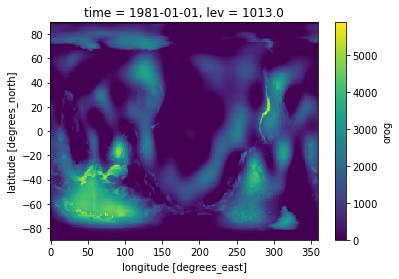

In [3]:
prova = xr.open_dataset('aclim_era5_sfc_1981_2010_steinberger-2007.nc')
prova.orog.plot()